<a href="https://colab.research.google.com/github/mirpouya/Diabeteic-Retinopathy-project---Western-University/blob/main/ViT%20first%20try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.6.4


In [ ]:
data_dir = pathlib.Path("../input/dr-zip/dr zip/DR/basedata/train")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" ])
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)

27670
['mild' 'moderate' 'no_dr' 'proliferative_dr' 'severe']
5


In [ ]:
data_dir2 = pathlib.Path("../input/dr-zip/dr zip/DR/basedata/test")

BATCH_SIZE = 16            # Can be of size 2^n, but not restricted to. for the better utilization of memory
IMG_HEIGHT = 224           # input Shape required by the model
IMG_WIDTH = 224             # input Shape required by the model
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

# Rescalingthe pixel values from 0~255 to 0~1 For RGB Channels of the image.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# training_data for model training
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))

val_data_gen = image_generator.flow_from_directory(directory=str(data_dir2),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))


Found 27670 images belonging to 5 classes.
Found 7456 images belonging to 5 classes.


Text(0.5, 1.0, 'Severe')

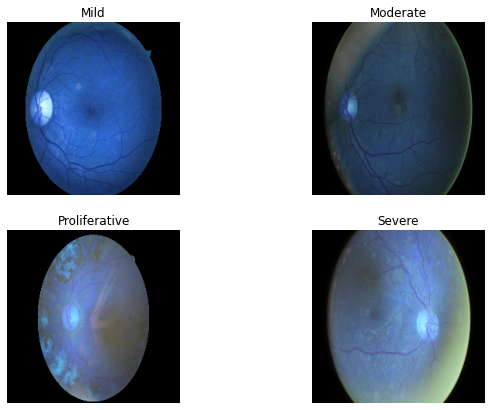

In [ ]:
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2

# reading images
Image1 = cv2.imread('../input/dr-zip/dr zip/DR/basedata/train/mild/10030_left.png')
Image2 = cv2.imread('../input/dr-zip/dr zip/DR/basedata/train/moderate/1002_right.png')
Image3 = cv2.imread('../input/dr-zip/dr zip/DR/basedata/train/proliferative_dr/10017_left.png')
Image4 = cv2.imread('../input/dr-zip/dr zip/DR/basedata/train/severe/10047_left.png')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Mild")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Moderate")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Proliferative")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Severe")

# Vision Transformer
A Vision Transformer is a model skilled at targeting smaller patches of an image for classification.

In [ ]:
!pip install --quiet vit-keras

In [ ]:
from vit_keras import vit

In [ ]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

2022-10-03 14:33:52.871058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:33:52.970055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:33:52.970933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 14:33:52.972694: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

353263616/353253686 [==============================] - 81s 0us/step


In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 60        
Total params: 87,466,867
Trainable params: 87,465,309
Non-trainable params: 1,558
________________________________

In [ ]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.SensitivityAtSpecificity(0.5), tf.keras.metrics.SpecificityAtSensitivity(0.5), tf.keras.metrics.AUC(curve='ROC')])


In [ ]:
import time
start = time.time()
history = model.fit(
      train_data_gen,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=1,
    validation_data=val_data_gen

)

# Saving the model
model.save('_TRsaved_model/')
print("Total time: ", time.time() - start, "seconds")

2022-10-03 14:35:22.248031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-03 14:35:39.034876: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1730/1730 [==============================] - 351s 190ms/step - loss: 0.9692 - accuracy: 0.7016 - precision: 0.7291 - recall: 0.6158 - sensitivity_at_specificity: 0.9186 - specificity_at_sensitivity: 0.9531 - auc: 0.8706 - val_loss: 0.8306 - val_accuracy: 0.7551 - val_precision: 0.7551 - val_recall: 0.7551 - val_sensitivity_at_specificity: 0.9642 - val_specificity_at_sensitivity: 0.9586 - val_auc: 0.9000


2022-10-03 14:42:11.433325: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Total time:  440.04167199134827 seconds
